In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [4]:
# Define the ticker symbol
tickerSymbol = 'IGM'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2021-01-01 00:00:00-05:00,57.827203,57.827203,56.038731,57.670753,643200,0.0,0.0,0.0
2021-01-08 00:00:00-05:00,58.026467,58.182917,56.844035,57.217869,876600,0.0,0.0,0.0
2021-01-15 00:00:00-05:00,57.229395,59.653547,56.720521,59.523449,772200,0.0,0.0,0.0
2021-01-22 00:00:00-05:00,59.325826,60.001029,57.263981,58.309723,1372800,0.0,0.0,0.0
2021-01-29 00:00:00-05:00,58.080821,60.579082,56.756760,60.579082,1294800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-07-26 00:00:00-04:00,90.769997,92.970001,88.239998,89.360001,1510900,0.0,0.0,0.0
2024-08-02 00:00:00-04:00,86.940002,87.680000,81.000000,87.300003,3133800,0.0,0.0,0.0
2024-08-09 00:00:00-04:00,87.000000,92.849998,86.750000,92.769997,2020700,0.0,0.0,0.0


In [5]:
max_weeks = 52

In [6]:

gap = (1/90)*100

option_prices = {
    4: [94/2.6],
    8: [94/3.55],
    17: [94/5.85],
    30: [94/7.6],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 4w 36.2
	 8w 26.5
	17w 16.1
	30w 12.4
mean option leverage, break even:
	 4w 36.2  3.9%
	 8w 26.5  4.9%
	17w 16.1  7.3%
	30w 12.4  9.2%
option gap: 1.11%


In [7]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [8]:
print('Option performance:\nweeks mean-profit median-profit positive w-max')
for p in option_performance:
    weeks = p[0]
    print(f'{weeks:4}w {p[1]:10.0f}% {p[4]:12.0f}% {p[2]:7.0f}% {p[3]:4.0f}%')

Option performance:
weeks mean-profit median-profit positive w-max
   4w         -2%          -52%      38%  -62%
   8w         11%          -53%      39%  -32%
  17w         28%           -4%      48%  -19%
  30w         74%           80%      59%   33%


In [9]:
from file import save_file

save_file(tickerSymbol, option_performance)

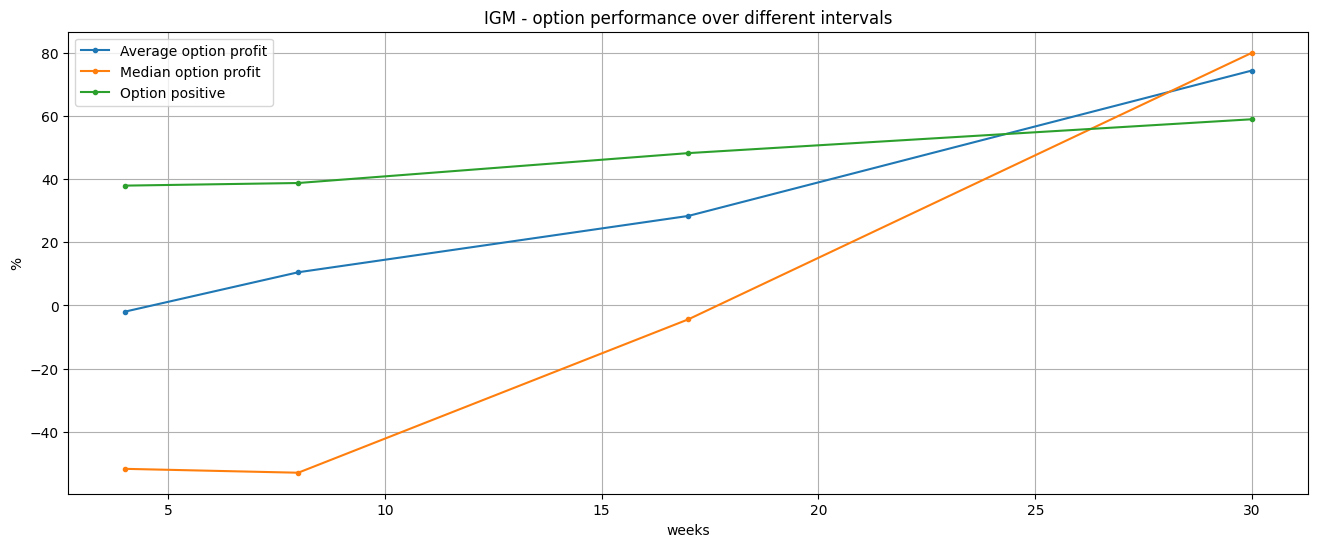

In [10]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_mean_profit, option_positive)]
plt.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_median_profit, label='Median option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

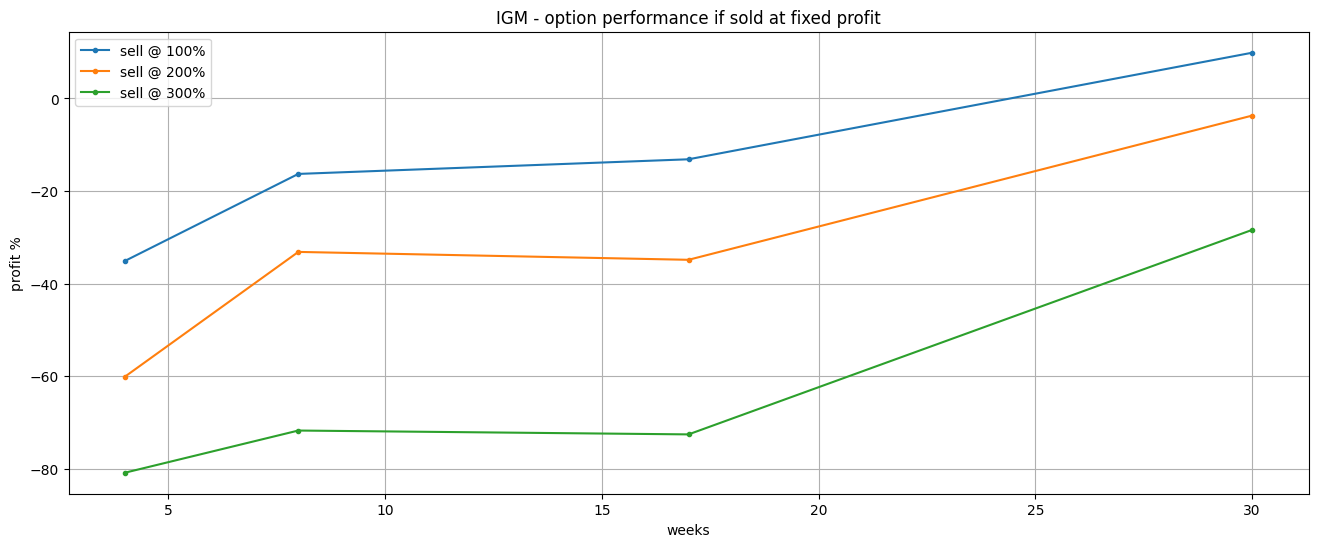

In [11]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        # print(f'{weeks}w q:{q:.2f} wmax:', wmax.describe())
        # display(wmax)
        data[weeks] = q * (percent + 100) - 100

    # display(data)
    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

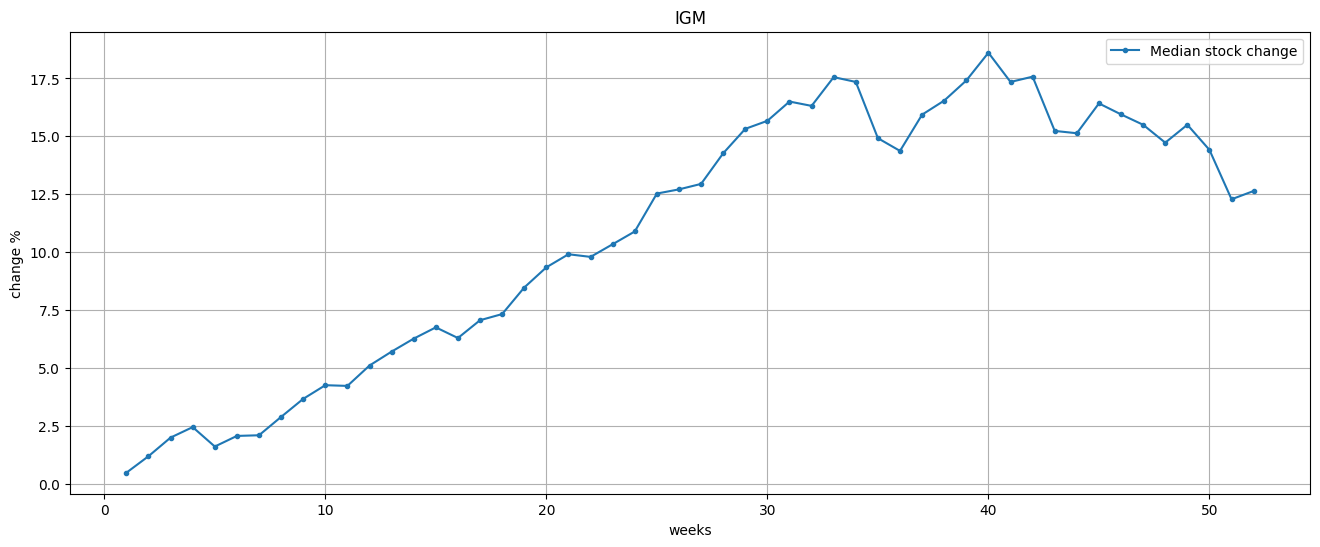

In [12]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


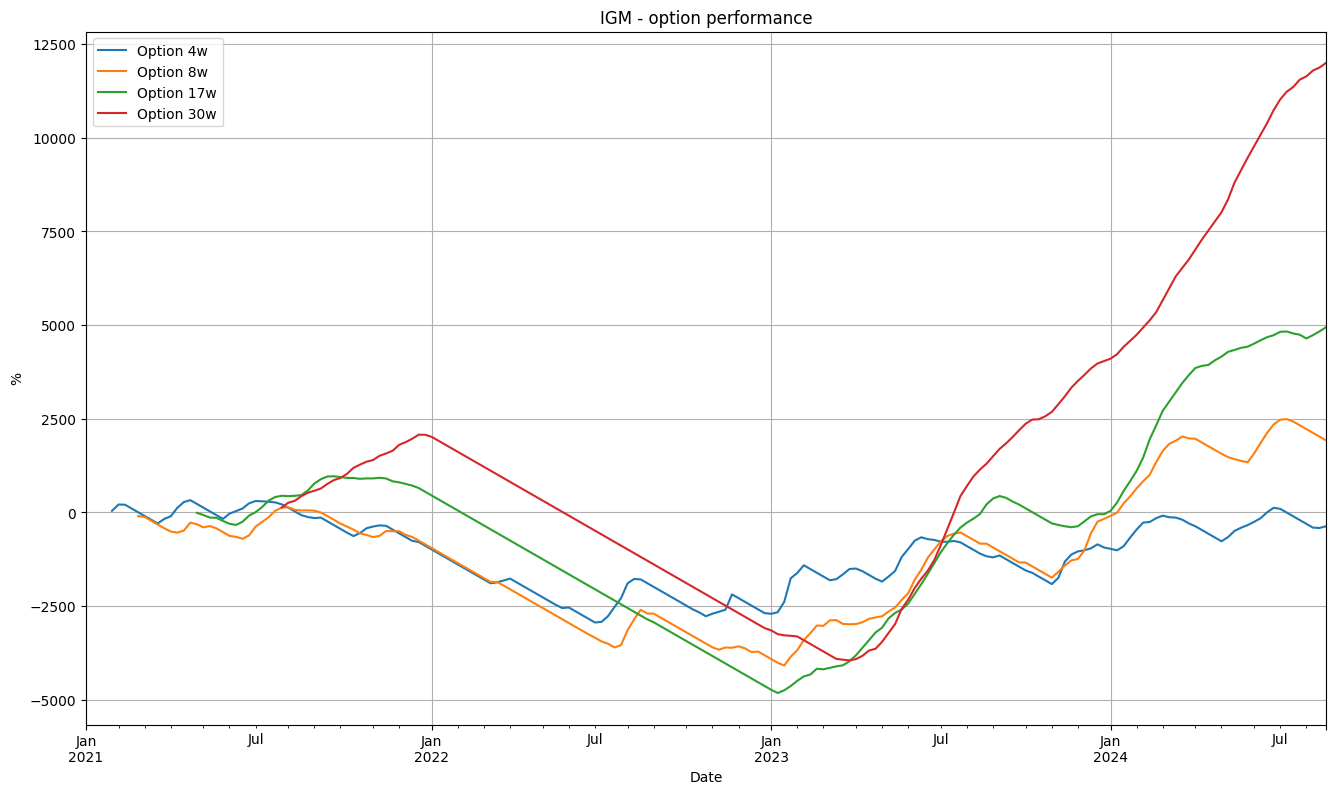

In [13]:
plt.figure(figsize=(16,9))

for w in [4,8,17,30]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


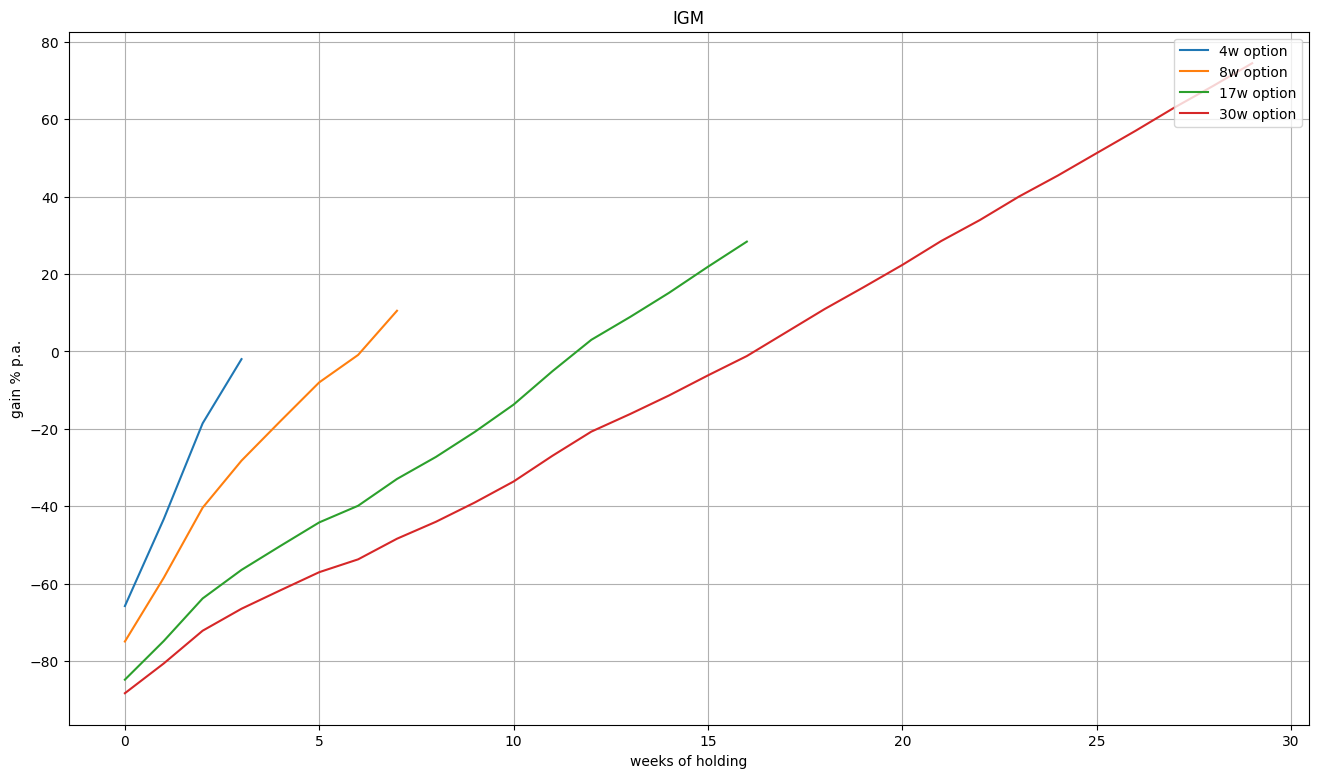

In [14]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()